In [1]:
import numpy as np
import pycolmap
import torch
import torch.nn as nn

from splat.gaussians import Gaussians
from splat.utils import read_images_binary, read_images_text

# stem = "/Users/derek/Desktop/intro_to_gaussian_splatting"
stem = "/home/da2986/intro_to_gaussian_splatting"


colmap_path = f"{stem}/data/treehill/sparse/0"
reconstruction = pycolmap.Reconstruction(colmap_path)

points3d = reconstruction.points3D
images = read_images_binary(f"{colmap_path}/images.bin")
cameras = reconstruction.cameras

all_points3d = []
all_point_colors = []


for idx, point in enumerate(points3d.values()):
    if point.track.length() >= 2:
        all_points3d.append(point.xyz)
        all_point_colors.append(point.color)

gaussians = Gaussians(
    torch.Tensor(all_points3d),
    torch.Tensor(all_point_colors),
    model_path=f"{stem}/data/point_clouds",
)

/var/tmp/ipykernel_11859/2632348526.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  torch.Tensor(all_points3d),


In [2]:
from splat.image import GaussianImage
from splat.utils import (
    build_rotation,
    get_extrinsic_matrix,
    getIntinsicMatrix,
    read_camera_file,
    read_image_file,
)

camera_dict = read_camera_file(colmap_path)
image_dict = read_image_file(colmap_path)
images = {}
for idx in image_dict.keys():
    image = image_dict[idx]
    camera = camera_dict[image.camera_id]
    image = GaussianImage(camera=camera, image=image)
    images[idx] = image


image_num = 100
rotation_matrix = build_rotation(torch.Tensor(image_dict[image_num].qvec).unsqueeze(0))
translation = torch.Tensor(image_dict[image_num].tvec).unsqueeze(0)
extrinsic_matrix = get_extrinsic_matrix(rotation_matrix, translation).T
focal_x, focal_y = camera_dict[image_dict[image_num].camera_id].params[:2]
c_x, c_y = camera_dict[image_dict[image_num].camera_id].params[2:4]
width = camera_dict[image_dict[image_num].camera_id].width
height = camera_dict[image_dict[image_num].camera_id].height
intrinsic_matrix = getIntinsicMatrix(focal_x, focal_y, height, width).T

In [3]:
from splat.render_engine.gaussianScene2 import GaussianScene2

scene = GaussianScene2(gaussians=gaussians)
TILE_SIZE = 16

In [4]:
processed_gaussians = scene.preprocess(
    extrinsic_matrix=extrinsic_matrix,
    intrinsic_matrix=intrinsic_matrix,
    focal_x=focal_x,
    focal_y=focal_y,
    width=width,
    height=height,
    tile_size=TILE_SIZE
)

In [5]:
height = 3400
width = 5100
with torch.no_grad():
    output_image = scene.render_cuda(
        preprocessed_gaussians=processed_gaussians, height=height, width=width, tile_size=TILE_SIZE
    )

starting sum
ending sum
tensor(195835, device='cuda:0') 26229
319 213
Creating key to tile map


Sorting array
Getting start indices
array_idx: 806 val_x: 1.000000 val_y: 0.000000 tile_x: 1 tile_y: 0 old_val: -1, array_length: 195835
array_idx: 807 val_x: 1.000000 val_y: 0.000000 tile_x: 1 tile_y: 0 old_val: 806, array_length: 195835
array_idx: 808 val_x: 1.000000 val_y: 0.000000 tile_x: 1 tile_y: 0 old_val: 806, array_length: 195835
array_idx: 809 val_x: 1.000000 val_y: 0.000000 tile_x: 1 tile_y: 0 old_val: 806, array_length: 195835


100%|██████████| 195835/195835 [00:20<00:00, 9424.67it/s]


> /home/da2986/intro_to_gaussian_splatting/splat/render_engine/gaussianScene2.py(475)render_cuda()
    473         import pdb; pdb.set_trace()
    474 
--> 475         print("Creating image")
    476         image = torch.zeros((height, width, 3), device=self.device, dtype=torch.float32)
    477 

tensor([[  0, 806, 838,  ...,  -1,  -1,  -1],
        [ -1,  -1,  -1,  ...,  -1,  -1,  -1],
        [  3,  -1,  -1,  ...,  -1,  -1,  -1],
        ...,
        [ -1,  -1,  -1,  ...,  -1,  -1,  -1],
        [ -1,  -1,  -1,  ...,  -1,  -1,  -1],
        [ -1,  -1,  -1,  ...,  -1,  -1,  -1]], device='cuda:0',
       dtype=torch.int32)
tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')
*** SyntaxError: invalid 

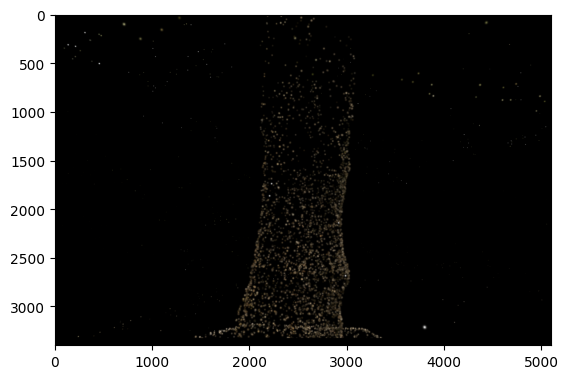

In [13]:
import matplotlib.pyplot as plt

plt.imshow(output_image.cpu().detach())
plt.show()